# OpenCV를 활용한 개체 탐지 후 색 그룹화
  -> 개체 탐지 후 색 추출하여 그룹화

## 개체 탐지

모듈 import

In [1]:
import cv2
import numpy as np

In [2]:
print(cv2.__version__)

4.11.0


In [3]:
def grabcut_segmentation(image_path):
    # 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print("이미지를 불러올 수 없습니다.")
        return
    
    # 창의 종료 버튼 활성화
    cv2.namedWindow("Original Image with Contours", cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("Original Image with Contours", cv2.WND_PROP_TOPMOST, 1)
    cv2.namedWindow("Segmented Object", cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("Segmented Object", cv2.WND_PROP_TOPMOST, 1)
    
    # 마스크 초기화
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # GrabCut을 위한 임시 배열 생성
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # 관심 영역(ROI) 설정 (이미지 중앙 기준)
    height, width = img.shape[:2]
    rect = (int(width*0.1), int(height*0.1), int(width*0.8), int(height*0.8))  # (x, y, w, h)
    
    # GrabCut 실행
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # 배경 제거하여 객체만 남기기
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented = img * mask2[:, :, np.newaxis]
    
    # 경계 검출
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 원본 이미지에 경계선을 그림 (초록색, 두께 2)
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    
    # 결과 출력
    cv2.imshow("Original Image with Contours", img)
    cv2.imshow("Segmented Object", segmented)
    
    print("창을 닫으려면 'q' 키 또는 ESC 키를 누르세요.")
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC 키 입력 시 닫기
            cv2.destroyAllWindows()
            break
        
        # 창이 닫혔는지 확인 후 종료
        if cv2.getWindowProperty("Original Image with Contours", cv2.WND_PROP_VISIBLE) < 1 or \
           cv2.getWindowProperty("Segmented Object", cv2.WND_PROP_VISIBLE) < 1:
            cv2.destroyAllWindows()
            break
    
    # 남아있는 모든 이벤트 처리 후 창 닫기
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)

# 실행 예시 (이미지 경로를 입력하여 테스트)
grabcut_segmentation("data/musinsa_images_outer/O66.jpg")


창을 닫으려면 'q' 키 또는 ESC 키를 누르세요.


## API로 이미지 불러오기

### 라이브러리 import

In [2]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

### Azure Custom Vision API 정보 (사용자가 직접 입력)

In [ ]:
# Azure Custom Vision API 정보 (사용자가 직접 입력)

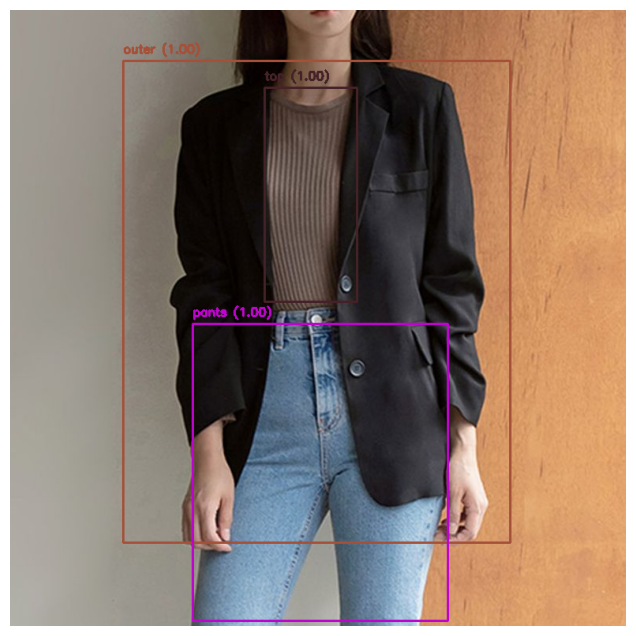

In [4]:
# 임계값 설정
THRESHOLD = 0.7  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 카테고리별 색상 선택
        color = category_colors[tag_name]

        # 바운딩 박스 및 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = "/Users/parkjiyon/Desktop/MSAI6/ML_project/data/musinsa_images_outer/O10.jpg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)


### 탐지한 객체 부분만 잘라오기

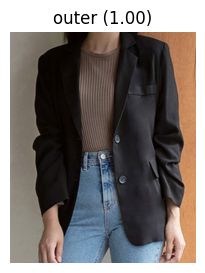

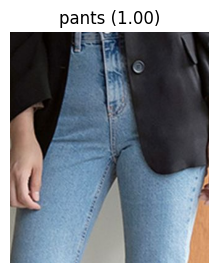

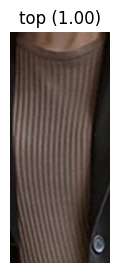

Tag: outer, Probability: 1.00, Image Shape: (610, 490, 3)
Tag: pants, Probability: 1.00, Image Shape: (376, 323, 3)
Tag: top, Probability: 1.00, Image Shape: (271, 117, 3)


In [5]:
import cv2
import matplotlib.pyplot as plt

def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

        # 새 창에 개별 이미지 출력
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.title(f"{tag_name} ({probability:.2f})")
        plt.axis("off")
        plt.show()

    return cropped_images  # 크롭된 이미지 리스트 반환

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")


### 테두리 추출 및 크롭

임시로 가장 성공한 코드

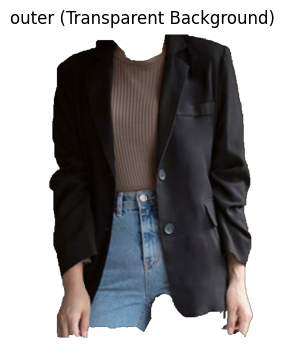

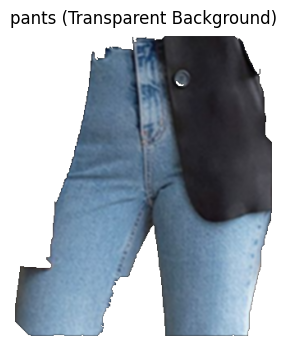

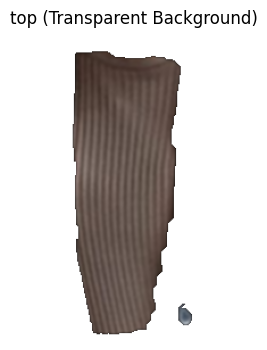

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background(cropped_images):
    final_images = []  # 최종 결과 저장

    for tag, prob, img in cropped_images:
        h, w, _ = img.shape
        
        # 초기 마스크 설정
        mask = np.zeros((h, w), np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        
        # GrabCut을 위한 초기 사각형 (조금 작게 설정)
        rect = (5, 5, w-10, h-10)
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        
        # 배경과 전경 분리
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        result = img * mask2[:, :, np.newaxis]
        
        # 경계 부드럽게 (가우시안 블러 적용)
        blurred = cv2.GaussianBlur(result, (5, 5), 0)

        # 알파 채널 추가
        alpha = mask2 * 255
        rgba = np.dstack([blurred, alpha])

        # 📌 최종 이미지 출력
        plt.figure(figsize=(4, 4))
        plt.imshow(rgba)
        plt.title(f"{tag} (Transparent Background)", fontsize=12)
        plt.axis("off")
        plt.show()

        final_images.append((tag, rgba))  # 결과 저장
    
    return final_images  # 최종 이미지 반환

# 🔥 실행
final_results = remove_background(cropped_objects)


